
Succesful score(s):
-168.0 -180.0 -174.0 -178.0 

Total games simulated:  10000
Total succesful games:  4
Percentage succesful games: 0.04 %
Train on 636 samples, validate on 160 samples
Epoch 1/20
636/636 [==============================] - 0s 695us/sample - loss: 1.1415 - accuracy: 0.3255 - val_loss: 1.1152 - val_accuracy: 0.3000
Epoch 2/20
636/636 [==============================] - 0s 115us/sample - loss: 1.1084 - accuracy: 0.3270 - val_loss: 1.0955 - val_accuracy: 0.3500
Epoch 3/20
636/636 [==============================] - 0s 114us/sample - loss: 1.1042 - accuracy: 0.3459 - val_loss: 1.0903 - val_accuracy: 0.3875
Epoch 4/20
636/636 [==============================] - 0s 113us/sample - loss: 1.1038 - accuracy: 0.3208 - val_loss: 1.0865 - val_accuracy: 0.4250
Epoch 5/20
636/636 [==============================] - 0s 115us/sample - loss: 1.0979 - accuracy: 0.3412 - val_loss: 1.0884 - val_accuracy: 0.4250
Epoch 6/20
636/636 [==============================] - 0s 114us/sample - loss: 1.09

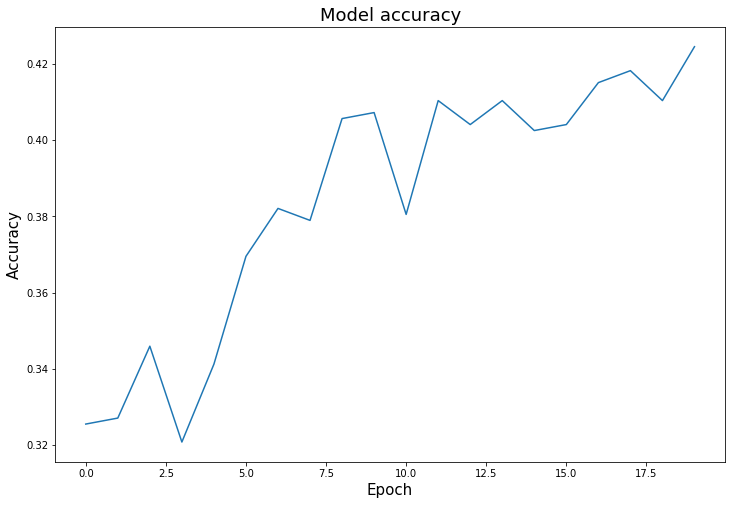

Game 1: Total reward: -38.0
Game 2: Total reward: -73.0
Game 3: Total reward: -52.0
Game 4: Total reward: -44.0
Game 5: Total reward: -70.0
Game 6: Total reward: -78.0
Game 7: Total reward: -54.0
Game 8: Total reward: -44.0
Game 9: Total reward: -54.0
Game 10: Total reward: -78.0
Average reward:  -58.5


In [68]:
# Imports
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import os,sys

import gym
import tensorflow as tf

# Initialize the Mountain Car environment.
env = gym.make('MountainCar-v0') # Mountain car environment.
env.reset() # Reset the environment so that it starts in its initial state.

# Setting up hyperparameters.
num_games = 10000 # Number of games that will be played.
min_score = -190 # Minimum score required for the data to be allowed to be training data.
num_steps = 200 # Steps in a single simulation.

max_actions = 3 # In this specific environment there are 3 possible actions.
threshold = -0.15 # Position threshold that will allow the reward to be equal to 1 instead of -1.
train_iterations = 20 # Number of training iterations.
play_games = 10 # Number of times network will be playing the game after training.

def random_game(printformat=1,visual=False):
    """
    A funtion defined in https://github.com/tankala/ai-examples/blob/master/mountain_car_game_understanding.ipynb.
    We did not use this function.
    """
    
    
    for i in range(num_steps):
        if visual == True:
            env.render() # For visualization.
        random_action = rd.randrange(0,max_actions)
        observation, reward, done, info = env.step(random_action)

        if printformat == 0:
            print(f'Step {i}')
            print(f' Action:   {random_action}')
            print(f' Position: {observation[0]}')
            print(f' Velocity: {observation[1]}')
            print(f' Reward:   {reward}')
            print(f' Done:     {done}')
            print(f' Info:     {info}')
        if printformat == 1:
            if i == 0:
                print('Step  Action  Pos    Vel   Reward  Done    Info')
            print(f'{i}     {random_action}       {observation[0]:.2f}  {observation[1]:.2f}  {reward}    {done}  {info}')

        # Statement to finish the simulation when the car has reached the top.
        # Will never occur with random motions.
        if done:
            break
    # Close and reset the environment.
    if visual == True:
        env.close()
        env.reset()


def make_train_sets():
    # Counter that keeps track of games that will be used for training.
    succesful_games_counter = 0
    obs_sucess = []
    act_sucess = []

    # Output some statistics.
    print('\nSuccesful score(s):')

    # Play a certain amount of games to generate training data.
    for i in range(num_games):
        sum_reward = 0 # Variable that hold the sum of all the rewards.
        OBS = []
        ACT = []
        good_OBS = []
        good_ACT = []
        # Iteratate through each game.
        for j in range(num_steps):
            random_action = rd.randrange(0,max_actions) # Make a random move.
            if j > 0:
                # This part is tricky. We need to store our position and the action that we are gonna take.
                # Not taking an action and store the action with where it leads us.
                OBS.append(observation) # Record our current obs
                ACT.append(random_action) # Record the action that we WILL take.
            observation,reward,done,info=env.step(random_action) # Obtain state values.
            # This is the important part: Set result equal to 1 if the position ...
            # ... of the car is above a certain threshold.
            if observation[0] > threshold:
                reward = 1
                """
                if j > 0:
                    # We tried to store "good moves" but it did not worked as well in practices as I assumed.
                    good_OBS.append(last_obs)
                    good_ACT.append(random_action)
                """
            #last_obs = observation  # For using in "good moves" part.
            # Find the sum of all the rewards through each game.
            sum_reward += reward

            # If the car has reached the top, stop the game (will probably ...
            # ... never happen with random moves.
            if done:
                break

        # If this occurs, the game is fit for training data.
        if sum_reward >= min_score:
            sys.stdout.write(f'{sum_reward} ')
            succesful_games_counter += 1
            #convert2training_data(game_states,train_data) # Construct training data.
            for i in range(len(OBS)):
                obs_sucess.append(OBS[i])
                act_sucess.append(ACT[i])
            
        env.reset() # Reset environment so all state variables will have their initial value again. IMPORTANT.

    # Print some statistics.
    print(f'\n\nTotal games simulated:  {num_games}')
    print(f'Total succesful games:  {succesful_games_counter}')
    fraction = float(succesful_games_counter)/num_games*100
    print(f'Percentage succesful games: {fraction:.2f} %')

    return obs_sucess, act_sucess

def acc_plotter(hs):
    plt.figure(figsize=(12,8))
    plt.plot(hs.history['accuracy'])
    #plt.plot(hs.history['val_accuracy'])
    plt.title('Model accuracy',fontsize=18)
    plt.xlabel('Epoch',fontsize=15)
    plt.ylabel('Accuracy',fontsize=15)
    plt.savefig('acc.png')
    plt.show()    
    plt.close()

def data_trainer(X,Y):
    # Create two lists so that we can store data in there in the correct format for the Keras model.

    train_X = np.asarray(X)
    train_Y = tf.one_hot(np.asarray(Y),depth = 3,axis = 1 ,dtype=tf.int8)
    
    #train
    tf.random.set_seed(27)
    tf.compat.v1.reset_default_graph()
    model = tf.keras.Sequential() # Make a neural network model.
    model.add(tf.keras.layers.BatchNormalization(axis=-1,input_shape=(2,))) # Batch normalization
    model.add(tf.keras.layers.Dense(8,activation='relu')) # Dense layer
    #model.add(tf.keras.layers.Dense(64,activation='relu'))
    model.add(tf.keras.layers.Dense(3,activation='softmax')) # softmax to classify
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

    hs = model.fit(train_X,train_Y,batch_size = 10,epochs=train_iterations,validation_split=0.2)

    acc_plotter(hs)

    return model


def play_game(model,visual=True):
    rewards = np.zeros(play_games) # Record reward of every game.
    succesful_games_counter = 0 # Counter for keeping track of succesful games.

    # Loop through number of games.
    for i in range(play_games):
        sum_reward = 0

        # Loop through all the steps.
        for j in range(num_steps):
            # Render the mountain_car if visual is set to True.
            if visual == True:
                env.render()
            if j == 0: action = 1 # Start the game with no push.
            else:
                action = np.argmax(model.predict(np.expand_dims(observation,axis = 0)))

            observation,reward,done,info = env.step(action)
            if observation[0]> threshold:
                reward = 1

            # Add the rewards together.
            sum_reward += reward

            # Stop the game if num_steps is reached or position of the mountaintop is reached.
            if done:
                break
        rewards[i] = sum_reward

        # Reset game.
        env.reset()

        print(f'Game {i+1}: Total reward: {sum_reward}')
    print('Average reward: ', np.average(rewards))


if __name__  == '__main__':
    # See what happens if Mountain car is launched with only random moves.
    #random_game(printformat=1,visual=True)

    # Prepare data.
    X,Y = make_train_sets()

    # Set up model and train it.
    model = data_trainer(X,Y)

    # Allow your game to be played with the trained model.
    play_game(model,visual=False)
